In [1]:
import numpy as np
import cv2

In [2]:
# read depth image
depth_scale = 0.00012498664727900177
depth_img = cv2.imread('depth.png')
dpt = depth_img[:, :, 2] + depth_img[:, :, 1] * 256
dpt = dpt * depth_scale

# read seg image
seg = cv2.imread('seg.png')[...,0]  # 255: fore ground, 0: background

# read intrinsics and extrinsics
K = np.load('intrinsic.npy')
print(K)

[[415.69219382   0.         320.        ]
 [  0.         415.69219382 240.        ]
 [  0.           0.           1.        ]]


In [3]:
# task1: convert depth image to point cloud
def depth2pc(depth, seg, K):
    # ------------TODO---------------
    # compute point cloud from depth image
    # for-loop is not allowed!!
    # ------------TODO --------------
    h,w = depth.shape
    depth = depth * (seg / 255)
    depth = depth.reshape(-1)
    useful_idx = np.where(depth!=0)
    K_inv = np.linalg.inv(K)

    xy_2D = np.vstack((depth * np.tile(np.arange(w), h), depth * np.repeat(np.arange(h), w), depth))
    full_pc = (K_inv @ xy_2D).T
    pc = full_pc[useful_idx[0]]
   
    return pc

partial_pc = depth2pc(dpt, seg, K)
# For debug and submission
np.savetxt('../results/pc_from_depth.txt', partial_pc)

one way chamfer distance:  0.009872248526500729


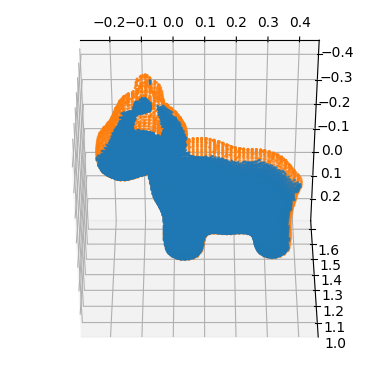

In [9]:
# task2: compute one-way chamfer distance to the complete shape
full_pc = np.loadtxt('aligned_full_pc.txt')

def random_sample(pc, num):
    permu = np.random.permutation(pc.shape[0])
    return pc[permu][:num]

partial_pc_sampled = random_sample(partial_pc, 2048)
full_pc_sampled = random_sample(full_pc, 2048)

# one way chamfer distance:  0.009976257336995639
# -----------TODO---------------
# implement one way chamfer distance
# -----------TODO---------------
one_way_CD = 0
dis = np.sum((partial_pc_sampled.reshape(2048, 1, -1) - full_pc_sampled.reshape(1, 2048, -1))**2, axis=2) ** 0.5
one_way_CD = np.sum(dis[np.arange(2048), np.argmin(dis, axis=1)]) / 2048
print('one way chamfer distance: ', one_way_CD)

# For submission
# np.savetxt('../results/one_way_CD.txt', one_way_CD)
with open('../results/one_way_CD.txt', 'w') as f:
    f.write(str(one_way_CD))

# For visualization.
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.scatter3D(partial_pc[:,0], partial_pc[:,1], partial_pc[:,2],s=1)
ax.scatter3D(full_pc[:,0], full_pc[:,1], full_pc[:,2],s=1)
ax.view_init(elev=-50, azim=-90)